In [26]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [27]:
start_day_to_analyze = '2020-04-16'
end_day_to_analyze = '2020-04-17'

In [31]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [32]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [33]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [34]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [35]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,1759,383,BB,sell_short,24,3.98,"{'rsi': 76.39469280271729, 'macd': [0.00821915...",2020-04-16T14:42:30.97225651Z,2020-04-16 14:42:31.314365,3.98,3.92
1,1760,383,BB,buy_short,24,3.99,"{'rsi': [61.510036187306326, 63.33161995473384...",2020-04-16T14:42:33.506438704Z,2020-04-16 14:42:34.194955,3.98,3.92
2,1761,383,BB,sell_short,24,3.98,"{'rsi': 76.39469280271729, 'macd': [0.00821915...",2020-04-16T14:42:37.718413205Z,2020-04-16 14:42:38.385322,3.98,3.92
3,1762,383,BB,buy_short,24,3.99,"{'rsi': [61.510036187306326, 63.33161995473384...",2020-04-16T14:42:41.552666383Z,2020-04-16 14:42:41.679775,3.98,3.92
4,1763,383,BB,sell_short,24,3.98,"{'rsi': 76.39469280271729, 'macd': [0.00821915...",2020-04-16T14:42:44.368436048Z,2020-04-16 14:42:44.800157,3.98,3.92
...,...,...,...,...,...,...,...,...,...,...,...
62,1729,383,ORBC,buy_short,38,2.57,"{'rsi': [67.78934465904871, 67.78934465904871,...",2020-04-16T14:27:37.618503933Z,2020-04-16 14:27:37.728631,2.54,2.50
63,1734,383,ORBC,sell_short,38,2.58,"{'rsi': 80.50579577768464, 'macd': [0.02111682...",2020-04-16T14:36:29.971300191Z,2020-04-16 14:36:30.333103,2.71,2.50
64,1789,383,ORBC,buy_short,38,2.54,"{'rsi': [52.6100288634167, 42.62450367131576, ...",2020-04-16T15:19:26.703399658Z,2020-04-16 15:19:26.869805,2.71,2.50
65,1726,384,SMMT,buy,320,4.45,"{'rsi': 67.75784881084383, 'macd': [0.06446239...",2020-04-16T14:08:17.149095356Z,2020-04-16 14:08:17.321602,4.14,5.38


In [36]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [42]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [43]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
8,383,momentum_short,PAPER,v0.1-291-gbc4ab2f,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-16 13:50:53.707350,None,None


,symbol,count,revenue
1,BB,22,-132.78
0,CGEN,25,-52.86
2,ORBC,4,-0.76
3,MDLA,2,0.92


TOTAL REVENUE: -185.48 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
9,384,momentum_long,PAPER,v0.1-291-gbc4ab2f,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-16 13:50:53.887669,None,None


,symbol,count,revenue
1,MOBL,2,-70.85
3,SMMT,2,-60.80
4,CREG,2,-38.36
5,KGC,2,-10.88
0,ECC,3,15.98
2,GPP,2,41.76


TOTAL REVENUE: -123.15 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
5,380,momentum_long,PAPER,v0.1-291-gbc4ab2f,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-16 13:45:01.939075,None,None


,symbol,count,revenue
0,MOBL,1,-1983.03


TOTAL REVENUE: -1983.03 $


In [39]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [40]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

CGEN analysis for run 383 with profit -52.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-96.11,-96.11,sell_short,2020-04-16 14:35:42.738366,13.73,None,None,7,"{'rsi': 76.6230722471786, 'macd': [0.11467695983389348, 0.1142693032163642, 0.1130465602457491, 0.1251592652089908, 0.13957281735729588], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.10970629965692731, 0.1106189003688147, 0.11110443234420157, 0.11391539891715942, 0.11904688260518671], 'resistances': [13.9], 'target_price': 13.32, 'distance_to_stop': 0.008750254367859535}",13.32,13.88
1,1.12,97.23,buy_short,2020-04-16 14:40:35.588707,13.89,None,None,7,"{'rsi': [69.81516974639706, 73.07150888033736, 73.45697481724314, 75.70417409885322, 78.62717554005498], 'reasons': 'stopped', 'movement': 0.009477019680804662}",13.32,13.88
2,-95.83,-96.95,sell_short,2020-04-16 14:40:37.432901,13.85,None,None,7,"{'rsi': 78.62431811511613, 'macd': [0.13655315262686152, 0.14305039076296744, 0.14730833641646512, 0.15375193102913265, 0.16421968258003616], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.12172361239299748, 0.12598896806699147, 0.1302528417368862, 0.13495265959533548, 0.14080606419227562], 'resistances': [13.9], 'target_price': 13.32, 'distance_to_stop': -0.0007127481119374524}",13.32,13.88
3,1.47,97.30,buy_short,2020-04-16 14:40:46.030384,13.90,None,None,7,"{'rsi': [69.81516974639706, 73.07150888033736, 73.45697481724314, 75.70417409885322, 78.9063284929646], 'reasons': 'stopped', 'movement': 0.0007199475878155916}",13.32,13.88
4,-26.29,-27.76,sell_short,2020-04-16 14:40:48.951904,13.88,None,None,2,"{'rsi': 78.62717554005498, 'macd': [0.13655315262686152, 0.14305039076296744, 0.14730833641646512, 0.15375193102913265, 0.16422765978801301], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.12172361239299748, 0.12598896806699147, 0.1302528417368862, 0.13495265959533548, 0.14080765963387099], 'resistances': [13.9], 'target_price': 13.32, 'distance_to_stop': -0.000719942404607616}",13.32,13.88
5,-151.21,-124.92,sell_short,2020-04-16 14:40:49.040734,13.88,None,None,9,"{'rsi': 78.62717554005498, 'macd': [0.13655315262686152, 0.14305039076296744, 0.14730833641646512, 0.15375193102913265, 0.16422765978801301], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.12172361239299748, 0.12598896806699147, 0.1302528417368862, 0.13495265959533548, 0.14080765963387099], 'resistances': [13.9], 'target_price': 13.32, 'distance_to_stop': -0.000719942404607616}",13.32,13.88
6,-53.91,97.30,buy_short,2020-04-16 14:40:54.062912,13.90,None,None,7,"{'rsi': [69.81516974639706, 73.07150888033736, 73.45697481724314, 75.70417409885322, 78.90076122794774], 'reasons': 'stopped', 'movement': 0.0006983441324693095}",13.32,13.88
7,-150.86,-96.95,sell_short,2020-04-16 14:41:01.039148,13.85,None,None,7,"{'rsi': 78.33760030470911, 'macd': [0.13655315262686152, 0.14305039076296744, 0.14730833641646512, 0.15375193102913265, 0.16342993899029068], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.12172361239299748, 0.12598896806699147, 0.1302528417368862, 0.13495265959533548, 0.1406481154743265], 'resistances': [13.9], 'target_price': 13.32, 'distance_to_stop': 0.0}",13.32,13.88
8,-53.70,97.16,buy_short,2020-04-16 14:41:02.899238,13.88,None,None,7,"{'rsi': [69.81516974639706, 73.07150888033736, 73.45697481724314, 75.70417409885322, 78.33760030470911], 'reasons': 'stopped', 'movement': 0.0}",13.32,13.88
9,-150.65,-96.95,sell_short,2020-04-16 14:41:04.862751,13.85,None,None,7,"{'rsi': 78.0400705253522, 'macd': [0.13655315262686152, 0.14305039076296744, 0.14730833641646512, 0.15375193102913265, 0.16263221819257012], 'supports': [12.46, 12.96, 12.9676, 13.25, 13.3], 'stop_price': 13.88, 'macd_signal': [0.12172361239299748, 0.12598896806699147, 0.1302528417368862, 0.13495265959533548, 0.1404885713147824], 'resistances': [13

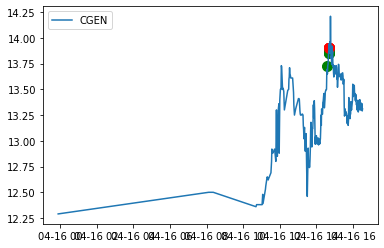

BB analysis for run 383 with profit -132.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-95.52,-95.52,sell_short,2020-04-16 14:42:31.314365,3.98,None,None,24,"{'rsi': 76.39469280271729, 'macd': [0.008219152738667468, 0.009142241491965297, 0.010160134486805639, 0.013633866782059023, 0.016997801010168345], 'supports': [3.7, 3.71, 3.71, 3.71, 3.72, 3.72, 3.7399, 3.755, 3.8404, 3.875, 3.905], 'stop_price': 3.98, 'macd_signal': [0.00991007090658583, 0.009756505023661724, 0.009837230916290508, 0.010596558089444211, 0.011876806673589039], 'resistances': [3.99, 4.0, 4.0, 4.0, 4.0], 'target_price': 3.925, 'distance_to_stop': -0.0025062656641604585}",3.92,3.98
1,0.24,95.76,buy_short,2020-04-16 14:42:34.194955,3.99,None,None,24,"{'rsi': [61.510036187306326, 63.33161995473384, 65.10985475620826, 74.45027371776266, 75.46094082308046], 'reasons': 'stopped', 'movement': -0.001253132832080285}",3.92,3.98
2,-95.28,-95.52,sell_short,2020-04-16 14:42:38.385322,3.98,None,None,24,"{'rsi': 76.39469280271729, 'macd': [0.008219152738667468, 0.009142241491965297, 0.010160134486805639, 0.013633866782059023, 0.016997801010168345], 'supports': [3.7, 3.71, 3.71, 3.71, 3.72, 3.72, 3.7399, 3.755, 3.8404, 3.875, 3.905], 'stop_price': 3.98, 'macd_signal': [0.00991007090658583, 0.009756505023661724, 0.009837230916290508, 0.010596558089444211, 0.011876806673589039], 'resistances': [3.99, 4.0, 4.0, 4.0, 4.0], 'target_price': 3.925, 'distance_to_stop': -0.0025062656641604585}",3.92,3.98
3,0.48,95.76,buy_short,2020-04-16 14:42:41.679775,3.99,None,None,24,"{'rsi': [61.510036187306326, 63.33161995473384, 65.10985475620826, 74.45027371776266, 75.936871795082], 'reasons': 'stopped', 'movement': -0.0006265664160401981}",3.92,3.98
4,-95.04,-95.52,sell_short,2020-04-16 14:42:44.800157,3.98,None,None,24,"{'rsi': 76.39469280271729, 'macd': [0.008219152738667468, 0.009142241491965297, 0.010160134486805639, 0.013633866782059023, 0.016997801010168345], 'supports': [3.7, 3.71, 3.71, 3.71, 3.72, 3.72, 3.7399, 3.755, 3.8404, 3.875, 3.905], 'stop_price': 3.98, 'macd_signal': [0.00991007090658583, 0.009756505023661724, 0.009837230916290508, 0.010596558089444211, 0.011876806673589039], 'resistances': [3.99, 4.0, 4.0, 4.0, 4.0], 'target_price': 3.925, 'distance_to_stop': -0.0025062656641604585}",3.92,3.98
5,0.72,95.76,buy_short,2020-04-16 14:42:47.190167,3.99,None,None,24,"{'rsi': [61.510036187306326, 63.33161995473384, 65.10985475620826, 74.45027371776266, 76.39469280271729], 'reasons': 'stopped', 'movement': 0.0}",3.92,3.98
6,-94.80,-95.52,sell_short,2020-04-16 14:42:55.911727,3.98,None,None,24,"{'rsi': 76.39469280271729, 'macd': [0.008219152738667468, 0.009142241491965297, 0.010160134486805639, 0.013633866782059023, 0.016997801010168345], 'supports': [3.7, 3.71, 3.71, 3.71, 3.72, 3.72, 3.7399, 3.755, 3.8404, 3.875, 3.905], 'stop_price': 3.98, 'macd_signal': [0.00991007090658583, 0.009756505023661724, 0.009837230916290508, 0.010596558089444211, 0.011876806673589039], 'resistances': [3.99, 4.0, 4.0, 4.0, 4.0], 'target_price': 3.925, 'distance_to_stop': -0.0025062656641604585}",3.92,3.98
7,0.96,95.76,buy_short,2020-04-16 14:42:56.835598,3.99,None,None,24,"{'rsi': [61.510036187306326, 63.33161995473384, 65.10985475620826, 74.45027371776266, 76.39469280271729], 'reasons': 'stopped', 'movement': 0.0}",3.92,3.98
8,-94.56,-95.52,sell_short,2020-04-16 14:43:01.174979,3.98,None,None,24,"{'rsi': 76.39469280271729, 'macd': [0.008219152738667468, 0.009142241491965297, 0.010160134486805639, 0.013633866782059023, 0.016997801010168345], 'supports': [3.7, 3.71, 3.71, 3.71, 3.72, 3.72, 3.7399, 3.755, 3.8404, 3.875, 3.905], 'stop_price': 3.98, 'macd_signal': [0.00991007090658583, 0.009756505023661724, 0.009837230916290508, 0.010596558089444211, 0.011876806673589039], 'resistances': [3.99, 4.0, 4.0, 4.0, 4.0], 'target_price': 3.925, 'distance_to_stop': -0.0025062656641604585}",3.92,3.98
9,1.20,95.76,buy_short,2020-04-16 14:43:14.844962,3.99,None,None,24,"{'rsi': [63.33161995473384, 65.109854756

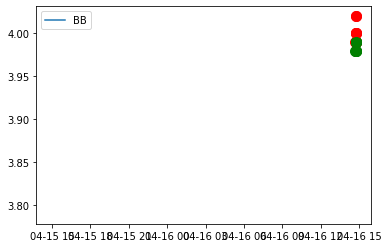

ORBC analysis for run 383 with profit -0.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-96.90,-96.90,sell_short,2020-04-16 14:27:35.143722,2.55,None,None,38,"{'rsi': 78.05390231893061, 'macd': [0.006757149127206041, 0.00873628804164106, 0.010195313823131436, 0.011222239277882018, 0.01508980492729739], 'supports': [2.4, 2.42, 2.46, 2.46, 2.4801], 'stop_price': 2.54, 'macd_signal': [0.0018290110099814638, 0.0032104664163133834, 0.0046074358976769935, 0.0059303965737179986, 0.007762278244433877], 'resistances': [2.56], 'target_price': 2.5001, 'distance_to_stop': -0.007812500000000007}",2.5,2.54
1,0.76,97.66,buy_short,2020-04-16 14:27:37.728631,2.57,None,None,38,"{'rsi': [67.78934465904871, 67.78934465904871, 67.82171753398026, 67.82171753398028, 78.05390231893061], 'reasons': 'stopped', 'movement': 0.0}",2.5,2.54
2,-97.28,-98.04,sell_short,2020-04-16 14:36:30.333103,2.58,None,None,38,"{'rsi': 80.50579577768464, 'macd': [0.021116823858293277, 0.02153605146741233, 0.02185042009031246, 0.02424087505024497, 0.026356007853038488], 'supports': [2.4, 2.42, 2.46, 2.46, 2.4801], 'stop_price': 2.715, 'macd_signal': [0.015027469898025177, 0.01632918621190261, 0.01743343298758458, 0.018794921400116658, 0.020307138690701023], 'resistances': [2.6472, 2.65, 2.66, 2.66, 2.7, 2.735], 'target_price': 2.5001, 'distance_to_stop': 0.04563835932986715}",2.5,2.71
3,-0.76,96.52,buy_short,2020-04-16 15:19:26.869805,2.54,None,None,38,"{'rsi': [52.6100288634167, 42.62450367131576, 38.67215349288553, 37.87785195840762, 29.27483019857525], 'reasons': 'low RSI', 'movement': -0.029462738301559713}",2.5,2.71


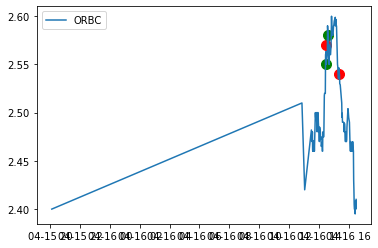

MDLA analysis for run 383 with profit 0.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-81.68,-81.68,sell_short,2020-04-16 14:49:40.289156,20.42,None,None,4,"{'rsi': 76.12716349899007, 'macd': [0.11453468239861309, 0.12382611188552062, 0.1300455952512074, 0.13343640876847473, 0.14095415259233235], 'supports': [19.09, 19.3, 19.6, 19.6785, 19.7], 'stop_price': 20.581, 'macd_signal': [0.07577067273964042, 0.08538176056881645, 0.09431452750529465, 0.10213890375793067, 0.109901953524811], 'resistances': [20.56, 20.56, 20.58, 20.601], 'target_price': 19.72, 'distance_to_stop': 0.00887254901960789}",19.72,20.58
1,0.92,82.60,buy_short,2020-04-16 15:07:43.416309,20.65,None,None,4,"{'rsi': [62.244622253618765, 64.44506064346763, 65.17368115651065, 67.99865456485102, 75.89505122794985], 'reasons': 'stopped', 'movement': 0.010784313725490316}",19.72,20.58


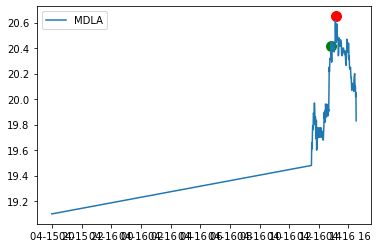

now=2020-04-16 10:29:39.024121
timestamp
2020-04-15 15:20:00-04:00    5.9200
2020-04-15 15:25:00-04:00    5.9300
2020-04-15 15:30:00-04:00    5.9557
2020-04-15 15:35:00-04:00    5.9300
2020-04-15 15:40:00-04:00    5.8900
2020-04-15 15:45:00-04:00    5.9400
2020-04-15 15:50:00-04:00    5.9600
2020-04-15 15:55:00-04:00    5.9800
2020-04-15 17:15:00-04:00    6.2500
2020-04-15 17:20:00-04:00    5.8900
Name: close, dtype: float64
timestamp
2020-04-15 14:10:00-04:00    5.93
2020-04-15 14:15:00-04:00    5.90
2020-04-15 14:20:00-04:00    5.95
2020-04-15 14:25:00-04:00    5.97
2020-04-15 14:30:00-04:00    5.98
2020-04-15 14:35:00-04:00    5.96
2020-04-15 14:40:00-04:00    5.94
2020-04-15 14:45:00-04:00    5.95
2020-04-15 14:50:00-04:00    5.95
2020-04-15 14:55:00-04:00    5.92
Name: close, dtype: float64
timestamp
2020-04-15 13:05:00-04:00    6.04
2020-04-15 13:10:00-04:00    6.07
2020-04-15 13:15:00-04:00    6.08
2020-04-15 13:20:00-04:00    6.07
2020-04-15 13:25:00-04:00    6.06
2020-04-15 13

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1797.05,-1797.05,buy,2020-04-16 14:29:39.024121,6.35,"[5.6, 5.64, 5.66, 5.6621, 5.73, 5.885, 5.89, 5.9, 6.02, 6.03, 6.08]",[6.551],283,"{'rsi': 65.42323566152659, 'macd': [0.013420480247257949, 0.01691908233967876, 0.02245879529140904, 0.02893624794257743, 0.03926546300611289], 'sell_macd': [0.007041471573319136, 0.009393348347946251, 0.013052040011968913, 0.017291903126635866, 0.024007486032523673], 'slow macd': [0.027261103449532698, 0.0277811112173989, 0.028814863088246767, 0.03019967060622708, 0.03254498984511045], 'macd_signal': [0.006203168851438051, 0.008346351549086193, 0.011168840297550763, 0.014722321826556098, 0.019630950062467456], 'resistances': [6.5, 6.551], 'sell_macd_signal': [0.0018169540732287533, 0.0033322329281722527, 0.005276194344931585, 0.007679336101272441, 0.010944966087522687]}",7.4,6.0
1,-1184.17,612.88,sell,2020-04-16 15:07:46.610422,6.52,None,None,94,"{'rsi': 72.42276257615511, 'reasons': 'scale-out', 'movement': 0.026960629921259954, 'sell_macd': [0.012438502564664944, 0.014531625841238238, 0.020129752734136197, 0.02683310157621044, 0.035401514939175094], 'sell_macd_signal': [0.010806882756525502, 0.01155183137346805, 0.01326741564560168, 0.015980552831723432, 0.019864745253213766]}",7.4,6.0
2,15.98,1200.15,sell,2020-04-16 15:50:35.137969,6.35,None,None,189,"{'rsi': 44.35227468307759, 'reasons': 'below cost & macd negative', 'movement': -0.02513341102864502, 'sell_macd': [0.01318850687002282, 0.010428874205326899, 0.0060651490873127045, 0.002586075630583551, -0.0002987358373953697], 'sell_macd_signal': [0.019971802191533078, 0.01806321659429184, 0.015663603092896015, 0.013048097600433522, 0.010378730912867744]}",7.4,6.0


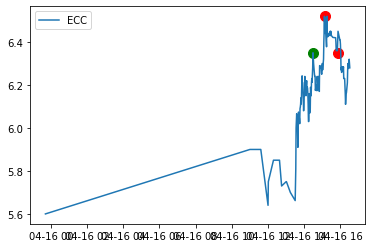

now=2020-04-16 10:57:33.971944
timestamp
2020-04-15 15:35:00-04:00    4.62
2020-04-15 15:40:00-04:00    4.62
2020-04-15 15:45:00-04:00    4.65
2020-04-15 15:50:00-04:00    4.63
2020-04-15 15:55:00-04:00    4.64
2020-04-15 16:00:00-04:00    4.62
2020-04-16 08:00:00-04:00    4.78
2020-04-16 08:25:00-04:00    5.24
2020-04-16 09:25:00-04:00    4.80
2020-04-16 09:30:00-04:00    4.90
Name: close, dtype: float64
MOBL analysis for run 384 with profit -70.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7085.00,-7085.00,buy,2020-04-16 14:57:33.971944,5.00,"[4.59, 4.595, 4.68, 4.87, 4.87, 4.92]",[5.24],1417,"{'rsi': 67.20222566213646, 'macd': [0.012248389396909865, 0.012226956624735053, 0.012070826029729531, 0.013007523415070388, 0.015587471242159978], 'sell_macd': [0.007310334434231791, 0.007278492092389399, 0.007159154006637358, 0.007752408043627312, 0.009412704591364118], 'slow macd': [0.0224219507576624, 0.02224906031197449, 0.022054411308865873, 0.02207995908919802, 0.022467990119261927], 'macd_signal': [0.010531525226998958, 0.010870611506546177, 0.011110654411182848, 0.011490028211960355, 0.01230951681800028], 'resistances': [5.24], 'sell_macd_signal': [0.006208247948203167, 0.006422296777040414, 0.006569668222959802, 0.006806216187093305, 0.007327513867947467]}",5.21,4.93
1,-70.85,7014.15,sell,2020-04-16 15:16:36.530181,4.95,None,None,1417,"{'rsi': 41.058219803186155, 'reasons': 'below cost & macd negative', 'movement': -0.009999999999999964, 'sell_macd': [0.00781552636058791, 0.0055287081534363125, 0.0036749704835328245, 0.0016632921630419517, -0.00018559084205449494], 'sell_macd_signal': [0.01113035310009516, 0.01001002411076339, 0.008743013385317277, 0.007327069140862212, 0.00582453714427887]}",5.21,4.93


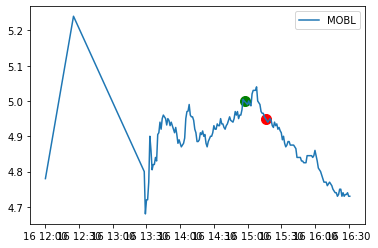

now=2020-04-16 10:54:25.355859
timestamp
2020-04-15 10:00:00-04:00    4.8650
2020-04-15 10:05:00-04:00    4.8650
2020-04-15 10:10:00-04:00    4.8300
2020-04-15 10:15:00-04:00    4.8400
2020-04-15 10:20:00-04:00    4.9000
2020-04-15 10:25:00-04:00    4.8999
2020-04-15 10:30:00-04:00    4.7001
2020-04-15 10:35:00-04:00    4.7578
2020-04-15 10:40:00-04:00    4.7331
2020-04-15 10:45:00-04:00    4.7896
Name: close, dtype: float64
timestamp
2020-04-14 13:05:00-04:00    5.4000
2020-04-14 13:10:00-04:00    5.3600
2020-04-14 13:15:00-04:00    5.3850
2020-04-14 13:20:00-04:00    5.3600
2020-04-14 13:25:00-04:00    5.3466
2020-04-14 13:30:00-04:00    5.3600
2020-04-14 13:35:00-04:00    5.3600
2020-04-14 13:50:00-04:00    5.3956
2020-04-14 14:15:00-04:00    5.3750
2020-04-14 14:30:00-04:00    5.4000
Name: close, dtype: float64
GPP analysis for run 384 with profit 41.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2672.64,-2672.64,buy,2020-04-16 14:54:25.355859,5.12,"[4.7001, 4.71, 4.71, 4.77, 4.79, 4.79, 4.79, 4.8, 4.8, 4.8, 4.8008, 4.83, 4.83, 4.84, 4.85, 4.85, 4.86, 4.94]","[5.36, 5.385, 5.39, 5.3956, 5.4, 5.4, 5.5584]",522,"{'rsi': 72.42514674982141, 'macd': [0.010011869055801093, 0.009794446169244075, 0.0190851325553405, 0.028539828355782504, 0.03961071733498045], 'sell_macd': [0.005137496129696828, 0.005008367652707513, 0.01107647055826444, 0.017219453724175438, 0.02437996718171398], 'slow macd': [0.013277529768931373, 0.01331801364713403, 0.015253192115408432, 0.017489030934696004, 0.020317783033632963], 'macd_signal': [0.019899073721340813, 0.017878148210921464, 0.01811954507980527, 0.020203601735000718, 0.024085024854996664], 'resistances': [5.36, 5.385, 5.39, 5.3956, 5.4, 5.4, 5.5584], 'sell_macd_signal': [0.01179329098579859, 0.010436306319180374, 0.010564339166997188, 0.011895362078432838, 0.014392283099089066]}",5.69,4.93
1,41.76,2714.40,sell,2020-04-16 15:15:26.917230,5.20,None,None,522,"{'rsi': 78.71296931265572, 'reasons': 'rsi max', 'movement': 0.02539062499999998, 'sell_macd': [0.028739069003409945, 0.0316274721241685, 0.035072624268600805, 0.03829387757246305, 0.04550142719141448], 'sell_macd_signal': [0.017261640279953243, 0.020134806648796293, 0.023122370172757194, 0.026156671652698367, 0.03002562276044159]}",5.69,4.93


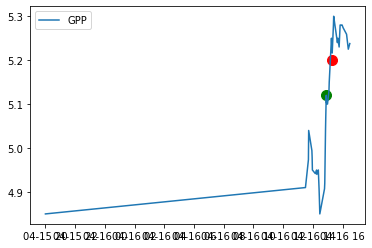

now=2020-04-16 10:08:17.321602
timestamp
2020-04-15 15:00:00-04:00    3.7300
2020-04-15 15:05:00-04:00    3.8038
2020-04-15 15:10:00-04:00    3.8500
2020-04-15 15:15:00-04:00    3.8500
2020-04-15 15:20:00-04:00    3.9275
2020-04-15 15:25:00-04:00    4.0317
2020-04-15 15:30:00-04:00    3.9650
2020-04-15 15:35:00-04:00    4.0100
2020-04-15 15:40:00-04:00    4.0001
2020-04-15 15:45:00-04:00    4.0100
Name: close, dtype: float64
timestamp
2020-04-15 13:20:00-04:00    3.8400
2020-04-15 13:25:00-04:00    3.8000
2020-04-15 13:30:00-04:00    3.8100
2020-04-15 13:35:00-04:00    3.8000
2020-04-15 13:40:00-04:00    3.8400
2020-04-15 13:45:00-04:00    3.8400
2020-04-15 13:50:00-04:00    3.8750
2020-04-15 13:55:00-04:00    3.8500
2020-04-15 14:00:00-04:00    3.8100
2020-04-15 14:05:00-04:00    3.8562
Name: close, dtype: float64
timestamp
2020-04-15 12:05:00-04:00    3.96
2020-04-15 12:10:00-04:00    4.00
2020-04-15 12:15:00-04:00    4.03
2020-04-15 12:20:00-04:00    3.97
2020-04-15 12:25:00-04:00  

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1424.0,-1424.0,buy,2020-04-16 14:08:17.321602,4.45,"[3.69, 3.9, 3.92, 3.98, 4.04, 4.2008]",[4.89],320,"{'rsi': 67.75784881084383, 'macd': [0.06446239550416433, 0.06306344635375627, 0.06177522754527409, 0.06460097944694532, 0.06808895054430053], 'sell_macd': [0.03759662132798436, 0.036634457354453254, 0.03575180416268253, 0.03755555746568273, 0.03978243591651953], 'slow macd': [0.06168473793875151, 0.06224403370492926, 0.06276461084333551, 0.06405321122402352, 0.0655393594171727], 'macd_signal': [0.06088688138183618, 0.0613221943762202, 0.06141280101003098, 0.06205043669741385, 0.06325813946679118], 'resistances': [4.89, 4.95], 'sell_macd_signal': [0.03547060173201006, 0.0357033728564987, 0.035713059117735466, 0.03608155878732492, 0.03682173421316384]}",5.38,4.14
1,-60.8,1363.2,sell,2020-04-16 14:49:09.978137,4.26,None,None,320,"{'rsi': 32.361211970116216, 'reasons': 'below cost & macd negative', 'movement': -0.06189312372019277, 'sell_macd': [0.023611990106275016, 0.020092425024500926, 0.014496758402020582, 0.003745631703957919, -0.008316877823156155], 'sell_macd_signal': [0.027460913491844135, 0.02598721579837549, 0.02368912431910451, 0.019700425796075192, 0.014096965072228924]}",5.38,4.14


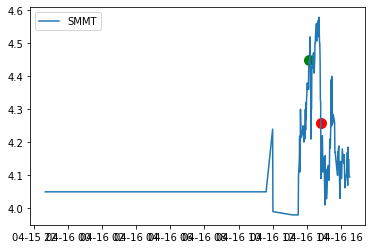

now=2020-04-16 10:20:10.964745
timestamp
2020-04-15 12:45:00-04:00    2.9000
2020-04-15 12:50:00-04:00    2.9001
2020-04-15 12:55:00-04:00    2.9100
2020-04-15 13:00:00-04:00    2.9100
2020-04-15 13:05:00-04:00    2.8801
2020-04-15 13:10:00-04:00    2.8884
2020-04-15 13:15:00-04:00    2.7400
2020-04-15 13:20:00-04:00    2.7000
2020-04-15 13:25:00-04:00    2.6700
2020-04-15 13:30:00-04:00    2.6700
Name: close, dtype: float64
timestamp
2020-04-15 11:25:00-04:00    3.1300
2020-04-15 11:30:00-04:00    3.2839
2020-04-15 11:35:00-04:00    3.1300
2020-04-15 11:40:00-04:00    3.1900
2020-04-15 11:45:00-04:00    2.9815
2020-04-15 11:50:00-04:00    3.0001
2020-04-15 11:55:00-04:00    3.0036
2020-04-15 12:00:00-04:00    2.9800
2020-04-15 12:05:00-04:00    2.9312
2020-04-15 12:10:00-04:00    2.8837
Name: close, dtype: float64
CREG analysis for run 384 with profit -38.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-415.11,-415.11,buy,2020-04-16 14:20:10.964745,3.03,"[2.32, 2.44, 2.45, 2.49, 2.5, 2.62, 2.65, 2.67, 2.67, 2.6701, 2.6857, 2.8905]","[3.19, 3.2839]",137,"{'rsi': 68.95173727069671, 'macd': [0.03486074570905284, 0.03800346764473739, 0.0456166718092228, 0.05345474718813037, 0.06323039317231016], 'sell_macd': [0.01960856455558302, 0.02166735314669177, 0.026626573436559386, 0.03170354283857879, 0.03801152493315785], 'slow macd': [0.024595478648903324, 0.02599479681223782, 0.0283601914170295, 0.030970880029567827, 0.03417412312326329], 'macd_signal': [0.037312776944693496, 0.037450915084702274, 0.03908406642960638, 0.04195820258131118, 0.046212640699510976], 'resistances': [3.19, 3.2839], 'sell_macd_signal': [0.02130317892739062, 0.02137601377125085, 0.022426125704312558, 0.024281609131165803, 0.027027592291564213]}",5.2,2.31
1,-38.36,376.75,sell,2020-04-16 14:30:13.175137,2.75,None,None,137,"{'rsi': 43.31520419344729, 'reasons': 'below cost & macd negative', 'movement': -0.09336674139522613, 'sell_macd': [0.0143301837911185, 0.010249037457666255, 0.007751403464617113, 0.001772060048415014, -0.0029101823544497307], 'sell_macd_signal': [0.021658713659248038, 0.019376778418931682, 0.01705170342806877, 0.013995774752138018, 0.010614583330820469]}",5.2,2.31


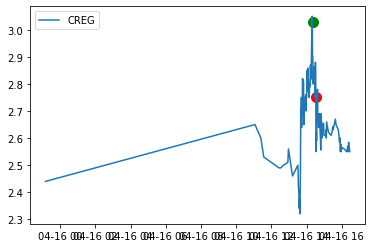

now=2020-04-16 10:08:02.229982
timestamp
2020-04-16 08:25:00-04:00    6.2500
2020-04-16 08:30:00-04:00    6.2300
2020-04-16 08:40:00-04:00    6.2200
2020-04-16 08:45:00-04:00    6.1500
2020-04-16 08:55:00-04:00    6.1799
2020-04-16 09:05:00-04:00    6.1100
2020-04-16 09:10:00-04:00    6.1400
2020-04-16 09:15:00-04:00    6.1400
2020-04-16 09:20:00-04:00    6.1400
2020-04-16 09:25:00-04:00    6.1000
Name: close, dtype: float64
timestamp
2020-04-15 15:20:00-04:00    6.0100
2020-04-15 15:25:00-04:00    5.9850
2020-04-15 15:30:00-04:00    5.9799
2020-04-15 15:35:00-04:00    5.9700
2020-04-15 15:40:00-04:00    5.9900
2020-04-15 15:45:00-04:00    6.0100
2020-04-15 15:50:00-04:00    6.0200
2020-04-15 15:55:00-04:00    6.0200
2020-04-15 16:00:00-04:00    5.9800
2020-04-15 16:40:00-04:00    5.9900
Name: close, dtype: float64
timestamp
2020-04-15 14:20:00-04:00    5.9899
2020-04-15 14:25:00-04:00    5.9500
2020-04-15 14:30:00-04:00    5.9500
2020-04-15 14:35:00-04:00    5.9850
2020-04-15 14:40:00

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1729.92,-1729.92,buy,2020-04-16 14:08:02.229982,6.36,"[6.02, 6.11, 6.165]",[6.36],272,"{'rsi': 74.56844811256305, 'macd': [0.04914589469083097, 0.05094221666575027, 0.050971332553042537, 0.05200871585444844, 0.05502081142273596], 'sell_macd': [0.02905273097772021, 0.030156721001653786, 0.030105846721580676, 0.030714180442023675, 0.032607503075588795], 'slow macd': [0.03853003531030019, 0.03974350596354448, 0.040636437570605644, 0.04171284295947597, 0.04319623257481098], 'macd_signal': [0.0450073038963622, 0.04619428645023981, 0.04714969567080036, 0.04812149970752998, 0.04950136205057117], 'resistances': [6.54, 6.58, 6.61], 'sell_macd_signal': [0.02661290560929446, 0.027321668687766327, 0.027878504294529198, 0.028445639524028093, 0.029278012234340234]}",7.46,6.0
1,-10.88,1719.04,sell,2020-04-16 14:33:06.663644,6.32,None,None,272,"{'rsi': 41.88506259232345, 'reasons': 'below cost & macd negative', 'movement': -0.007855459544383318, 'sell_macd': [0.010924258158524935, 0.008466026283613814, 0.005661351754026711, 0.0021036657341655385, -0.0006958774726628647], 'sell_macd_signal': [0.018790444014249945, 0.016725560468122718, 0.014512718725303516, 0.01203090812707592, 0.009485551007128164]}",7.46,6.0


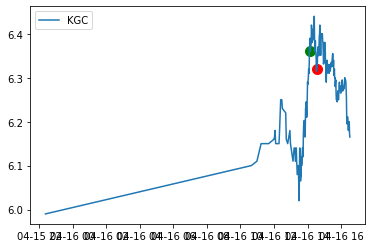

now=2020-04-16 09:47:18.706400
timestamp
2020-04-15 15:35:00-04:00    4.62
2020-04-15 15:40:00-04:00    4.62
2020-04-15 15:45:00-04:00    4.65
2020-04-15 15:50:00-04:00    4.63
2020-04-15 15:55:00-04:00    4.64
2020-04-15 16:00:00-04:00    4.62
2020-04-16 08:00:00-04:00    4.78
2020-04-16 08:25:00-04:00    5.24
2020-04-16 09:25:00-04:00    4.80
2020-04-16 09:30:00-04:00    4.90
Name: close, dtype: float64
MOBL analysis for run 380 with profit -1983.03


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1983.03,-1983.03,buy,2020-04-16 13:47:18.706400,4.97,"[4.59, 4.595, 4.68]",[5.24],399,"{'rsi': 62.711514317378224, 'macd': [0.07378842518490547, 0.07498192864717979, 0.07745567718717083, 0.07930883428047242, 0.08065465440450659], 'sell_macd': [0.04574930575810576, 0.046292648476504716, 0.04767327074439365, 0.048649427436976644, 0.04929773878915977], 'slow macd': [0.03609130084675538, 0.03807739458808257, 0.04032357296490918, 0.04248557302617151, 0.044566668527515674], 'macd_signal': [0.058112390121040775, 0.06148629782626858, 0.06468017369844903, 0.0676059058148537, 0.07021565553278428], 'resistances': [5.24], 'sell_macd_signal': [0.03626032219340995, 0.038266787450028907, 0.04014808410890185, 0.04184835277451681, 0.0433382299774454]}",5.72,4.72


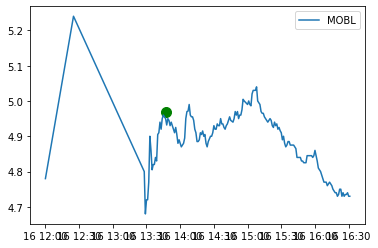

In [41]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

